American Sign Language (ASL) is a complete, natural language that has the same linguistic properties as spoken languages, with grammar that differs from English. ASL is expressed by movements of the hands and face. It is the primary language of many North Americans who are deaf and hard of hearing, and is used by many hearing people as well.

In [3]:
project_name='sign-language'

In [4]:
!pip install opendatasets --upgrade --quiet #to download kaggle datasets

###Downloading the dataset.

you will be asked to provide your Kaggle username and credentails, which you can obtained on your account page on Kaggle.
enter the username and key manually when prompted.

In [5]:
import opendatasets as od
dataset_url = 'https://www.kaggle.com/datamunge/sign-language-mnist'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: dnandhakumars
Your Kaggle Key: ··········


 10%|▉         | 6.00M/62.6M [00:00<00:01, 59.3MB/s]

100%|██████████| 62.6M/62.6M [00:01<00:00, 54.8MB/s]


In [6]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import random_split, Dataset
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
from torchvision.transforms import transforms
%matplotlib inline

In [7]:
train_df = pd.read_csv('/content/sign-language-mnist/sign_mnist_train.csv')
test_df = pd.read_csv('/content/sign-language-mnist/sign_mnist_test.csv')
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,156,158,160,163,165,159,166,168,170,170,171,171,171,172,171,171,170,170,169,111,121,129,135,141,144,148,151,154,157,160,...,205,206,206,207,207,206,206,204,205,204,203,202,142,151,160,172,196,188,188,190,135,96,86,77,77,79,176,205,207,207,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,157,158,156,154,154,153,152,151,149,149,148,147,146,144,142,143,138,92,108,158,159,159,159,160,160,160,160,160,160,160,...,100,78,120,157,168,107,99,121,133,97,95,120,135,116,95,79,69,86,139,173,200,185,175,198,124,118,94,140,133,84,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,186,185,185,185,184,184,184,181,181,179,179,179,178,178,109,52,66,77,83,188,189,189,188,188,189,188,188,188,188,187,...,203,204,203,201,200,200,199,198,196,195,194,193,198,166,132,114,89,74,79,77,74,78,132,188,210,209,206,205,204,203,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,211,209,207,208,207,206,203,202,201,200,198,197,195,192,197,171,51,52,54,212,213,215,215,212,212,213,212,212,211,211,...,247,242,233,231,230,229,227,225,223,221,220,216,58,51,49,50,57,60,17,15,18,17,19,1,159,255,237,239,237,236,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,186,188,189,189,190,191,189,190,190,187,190,192,193,191,191,192,192,194,194,166,169,172,174,177,180,182,185,186,187,190,...,90,77,88,117,123,127,129,134,145,152,156,179,105,106,105,104,104,104,175,199,178,152,136,130,136,150,118,92,85,76,92,105,105,108,133,163,157,163,164,179


###Separating image and label dataframe.

In [8]:
# getting pixel excluding the label column
train_df_img = train_df.drop('label', axis=1)
test_df_img = test_df.drop('label', axis=1)

# getting labels excluding pixels data
train_df_lbl = train_df['label']
test_df_lbl = test_df['label']
train_df_img

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,107,118,127,134,139,143,146,150,153,156,158,160,163,165,159,166,168,170,170,171,171,171,172,171,171,170,170,169,111,121,129,135,141,144,148,151,154,157,160,163,...,205,206,206,207,207,206,206,204,205,204,203,202,142,151,160,172,196,188,188,190,135,96,86,77,77,79,176,205,207,207,207,207,207,207,206,206,206,204,203,202
1,155,157,156,156,156,157,156,158,158,157,158,156,154,154,153,152,151,149,149,148,147,146,144,142,143,138,92,108,158,159,159,159,160,160,160,160,160,160,160,159,...,100,78,120,157,168,107,99,121,133,97,95,120,135,116,95,79,69,86,139,173,200,185,175,198,124,118,94,140,133,84,69,149,128,87,94,163,175,103,135,149
2,187,188,188,187,187,186,187,188,187,186,185,185,185,184,184,184,181,181,179,179,179,178,178,109,52,66,77,83,188,189,189,188,188,189,188,188,188,188,187,185,...,203,204,203,201,200,200,199,198,196,195,194,193,198,166,132,114,89,74,79,77,74,78,132,188,210,209,206,205,204,203,202,201,200,199,198,199,198,195,194,195
3,211,211,212,212,211,210,211,210,210,211,209,207,208,207,206,203,202,201,200,198,197,195,192,197,171,51,52,54,212,213,215,215,212,212,213,212,212,211,211,209,...,247,242,233,231,230,229,227,225,223,221,220,216,58,51,49,50,57,60,17,15,18,17,19,1,159,255,237,239,237,236,235,234,233,231,230,226,225,222,229,163
4,164,167,170,172,176,179,180,184,185,186,188,189,189,190,191,189,190,190,187,190,192,193,191,191,192,192,194,194,166,169,172,174,177,180,182,185,186,187,190,191,...,90,77,88,117,123,127,129,134,145,152,156,179,105,106,105,104,104,104,175,199,178,152,136,130,136,150,118,92,85,76,92,105,105,108,133,163,157,163,164,179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27450,189,189,190,190,192,193,193,193,193,194,193,193,194,194,195,195,196,194,195,196,196,197,196,197,197,196,195,195,189,190,192,192,193,194,195,196,196,196,193,194,...,115,92,132,173,118,84,53,135,253,213,219,208,82,82,84,85,85,87,84,87,78,113,216,189,172,175,155,131,116,93,132,165,99,77,52,200,234,200,222,225
27451,151,154,157,158,160,161,163,164,166,167,169,169,169,169,169,169,169,169,169,167,167,167,166,165,164,164,163,162,153,156,159,160,162,163,164,165,167,169,172,171,...,199,200,199,199,198,199,198,197,196,195,195,194,66,67,65,62,61,41,32,37,33,30,28,38,187,202,199,199,199,199,198,198,198,198,198,196,195,195,195,194
27452,174,174,174,174,174,175,175,174,173,173,173,172,171,171,171,170,169,168,166,166,165,165,163,162,161,160,158,156,178,178,177,176,177,177,177,176,176,176,175,174,...,110,85,90,166,205,207,205,203,202,201,200,198,217,217,217,218,218,211,203,200,189,171,157,145,136,129,128,125,101,77,121,196,209,208,206,204,203,202,200,200
27453,177,181,184,185,187,189,190,191,191,190,191,193,192,191,191,191,191,190,190,189,187,186,184,183,182,181,179,177,179,182,185,187,189,190,192,192,192,192,194,194,...,190,173,140,80,28,60,70,61,61,78,100,86,136,135,135,135,132,132,136,136,137,144,103,120,197,200,195,196,170,149,119,56,27,58,102,79,47,64,87,93


###Getting label index from dataset.

In [9]:
num_classes = np.unique(train_df_lbl)
print("label index: ",num_classes)

label index:  [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]


Training Datasets = 27,455

Test Datasets = 7172

### Alphabets index except j and z

To understand the output manually created the dict with appropriate keys.

9=J or 25=Z because of gesture motions these are excluded from the datasets.

In [10]:
alphabets = {
    0:'a', 1:'b', 2:'c', 3:'d', 4:'e',
    5:'f', 6:'g', 7:'h', 8:'i',  9:'j', 10:'k',
    11:'l', 12:'m', 13:'n', 14:'o', 15:'p',
    16:'q', 17:'r', 18:'s', 19:'t', 20:'u',
    21:'v', 22:'w', 23:'x', 24:'y', 25:'z'
}

###Transforms

changing the composition and structure of image so that model can learn different datas.

In [11]:
# Data transforms (normalization & data augmentation)
train_tfms = transforms.Compose([
                         transforms.ToPILImage(mode='L'),
                         transforms.ToTensor(),
                         transforms.RandomHorizontalFlip(p=0.5),
                         transforms.RandomVerticalFlip(p=0.5),
                         transforms.Normalize(0.5, 0.5)
])

###Custom Dataset

creating a custom dataset using pixel and label dataframes.
we have created a class which gets the pixel dataframe converts it to numpy arrays and then reshaping the array to (28x28).

In [12]:
# custom dataset
class CustomImageDataset(Dataset):
    def __init__(self, images, labels=None, transforms=None):
        self.img = images
        self.lbl = labels
        self.transforms = transforms
         
    def __len__(self):
        return (len(self.img))
    
    def __getitem__(self, i):
        data = self.img.iloc[i]
        pxl_size = len(self.img.iloc[i]) ** 0.5
        data = np.asarray(data).astype(np.uint8).reshape(-1, int(pxl_size))
        if self.transforms:
            data = self.transforms(data)
        # check if label is present or not
        if self.lbl is not None:
            return (data, self.lbl[i])
        else:
            return data

    def __len__(self):
        return (len(self.img))

In [13]:
dataset = CustomImageDataset(train_df_img, train_df_lbl, train_tfms)
test_ds = CustomImageDataset(train_df_img, train_df_lbl, train_tfms)

###Sample Image from our custom dataset

Label (Alphabet) :  d


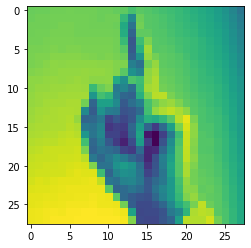

In [14]:
img, lbl = dataset[0]
print("Label (Alphabet) : ",alphabets[lbl])
plt.imshow(img[0])

Seed value is fixed inorder to get same validation set.

In [15]:
random_seed = 43
torch.manual_seed(random_seed)
val_size = 3000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(24455, 3000)

In [16]:
batch_size = 128
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=0, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size*2, num_workers=0, pin_memory=True)

Below are the images of a batch which are processed through transform normalization, horizontal and vertical flip.

In [17]:
def show_batch(trainloader):
  for images, _ in trainloader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([128, 1, 28, 28])


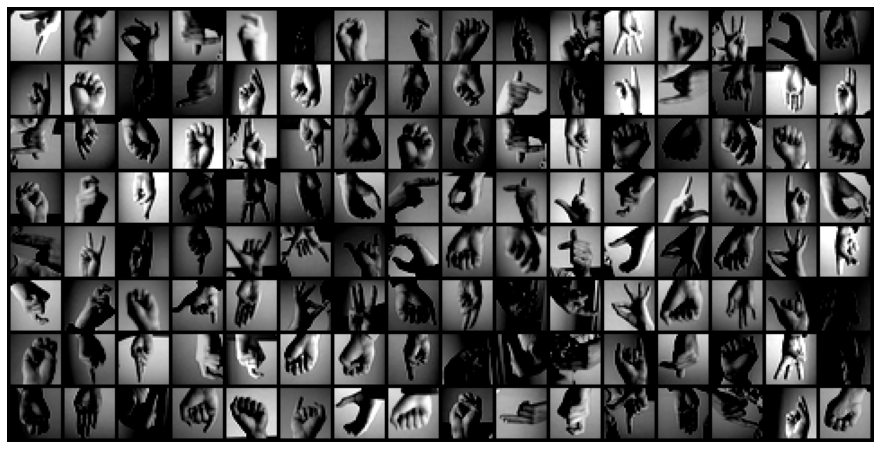

In [18]:
show_batch(train_dl)

In [19]:
# Reused code from "Deep Learning with PyTorch: Zero to GANs"
# https://jovian.ai/learn/deep-learning-with-pytorch-zero-to-gans/
# To move Model and Data to GPU
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [20]:
# Get available device
device = get_default_device()
device

device(type='cuda')

In [21]:
# Reused code from "Deep Learning with PyTorch: Zero to GANs"
# https://jovian.ai/learn/deep-learning-with-pytorch-zero-to-gans/
# Set of helper function to get accuracy and loss 
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [22]:
def conv_block(in_channels, out_channels,pool=False):
    layers = [
              nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.ReLU()]
    if pool: layers.append(nn.MaxPool2d(2, 2))
    return nn.Sequential(*layers)

In [23]:
class AslModel(ImageClassificationBase):
  def __init__(self, in_channels, out_classes):
    super().__init__()
    self.network = nn.Sequential(
        conv_block(in_channels, 32),
        conv_block(32, 64, pool=True),
        conv_block(64, 128),
        conv_block(128, 128, pool=True),
        conv_block(128, 256),
        conv_block(256, 256, pool=True),

        nn.Flatten(), 
        nn.Linear(256*3*3, 1024),# 2304
        nn.ReLU(),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Linear(512, out_classes)
    )
        
  def forward(self, xb):
    return self.network(xb)



In [24]:
#as the output label index starts from 0, we assigned the value 25 to the out_classes
in_channels = 1
out_classes = 25

In [25]:
model = AslModel(in_channels, out_classes)
to_device(model, device);

In [26]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [27]:
for images, labels in train_dl:
  print("image shape", images.shape)
  out = model(images)
  print("out shape", out.shape)
  print('out[0]:', out[0])
  break


image shape torch.Size([128, 1, 28, 28])
out shape torch.Size([128, 25])
out[0]: tensor([ 0.0129,  0.0027, -0.0366,  0.0294, -0.0178,  0.0159, -0.0398,  0.0034,
         0.0337, -0.0009,  0.0578,  0.0456, -0.0311,  0.0154, -0.0203, -0.0169,
         0.0109, -0.0160,  0.0025,  0.0070, -0.0315, -0.0149, -0.0197, -0.0352,
         0.0344], device='cuda:0', grad_fn=<SelectBackward>)


In [28]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [29]:
evaluate(model, val_dl)

{'val_acc': 0.03780287504196167, 'val_loss': 3.2191319465637207}

In [30]:
# Adam optimizer is used.
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [31]:
%%time
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 2.7393, val_loss: 2.0712, val_acc: 0.2559
Epoch [1], train_loss: 1.5201, val_loss: 1.3536, val_acc: 0.5179
Epoch [2], train_loss: 0.4881, val_loss: 0.2666, val_acc: 0.9057
Epoch [3], train_loss: 0.1544, val_loss: 0.0684, val_acc: 0.9738
Epoch [4], train_loss: 0.0713, val_loss: 0.0339, val_acc: 0.9902
Epoch [5], train_loss: 0.0302, val_loss: 0.0514, val_acc: 0.9846
Epoch [6], train_loss: 0.0521, val_loss: 0.0300, val_acc: 0.9904
Epoch [7], train_loss: 0.0335, val_loss: 0.0188, val_acc: 0.9928
Epoch [8], train_loss: 0.0203, val_loss: 0.0267, val_acc: 0.9919
Epoch [9], train_loss: 0.0219, val_loss: 0.0161, val_acc: 0.9963
CPU times: user 3min 32s, sys: 1.81 s, total: 3min 33s
Wall time: 3min 33s


In [32]:
train_time='3min 33s'

Testing with individual images

In [33]:
def test_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return alphabets[preds[0].item()]

Label: c , Predicted: c


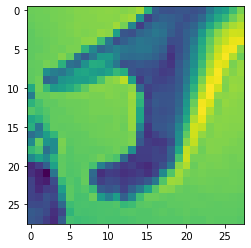

In [34]:
img, label = test_ds[705]
predicted_image = test_image(img, model)
print('Label:', alphabets[label], ', Predicted:', predicted_image)
plt.imshow(img[0])

Label: r , Predicted: r


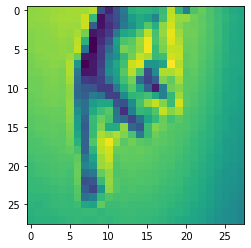

In [35]:
img, label = test_ds[2186]
predicted_image = test_image(img, model)
print('Label:', alphabets[label], ', Predicted:', predicted_image)
plt.imshow(img[0])

In [ ]:
# load model state
path = '/content/asl-layer9.pth'
model2 = to_device(AslModel(), device)
evaluate(model2, test_loader)

In [36]:
# Save model state
torch.save(model.state_dict(), 'asl-layer9.pth')

In [ ]:
jovian.reset()
jovian.log_hyperparams({
    'arch':'aslmodel',
    'num_epochs': num_epochs,
    'opt_func': opt_func.__name__,
    'batch_size': batch_size,
    'lr': lr,
})

[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: 

In [ ]:
jovian.log_dataset(dataset_url=dataset_url, val_size=val_size, random_seed=random_seed)

In [ ]:
jovian.log_metrics(val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'],
                   train_loss=history[-1]['train_loss'],
                   time=train_time)

In [ ]:
jovian.commit(project=project_name, outputs=['asl-layer9.pth'])